In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Using TensorFlow backend.


In [2]:
data = pd.read_csv(r'C:\Users\user\Downloads\tweets-sentiment-analysis\data.csv',encoding = "ISO-8859-1")
# Keeping only the neccessary columns
data = data[['Text','Sentiment']]

In [3]:
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 11
BATCH_SIZE = 40

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [4]:
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [5]:
%%time
data.Sentiment = data.Sentiment.apply(lambda x: decode_sentiment(x))

Wall time: 109 ms


In [6]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [7]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
%%time
data.Text = data.Text.apply(lambda x: preprocess(x))

Wall time: 1.12 s


In [9]:
data_train, data_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(data_train))
print("TEST size:", len(data_test))


TRAIN size: 22408
TEST size: 5602


In [10]:
%%time
documents = [_text.split() for _text in data_train.Text]

Wall time: 23.1 ms


In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=8)

In [12]:
w2v_model.build_vocab(documents)


2019-12-03 01:21:22,911 : INFO : collecting all words and their counts
2019-12-03 01:21:22,911 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-03 01:21:22,970 : INFO : PROGRESS: at sentence #10000, processed 67069 words, keeping 12807 word types
2019-12-03 01:21:22,995 : INFO : PROGRESS: at sentence #20000, processed 133318 words, keeping 19655 word types
2019-12-03 01:21:23,005 : INFO : collected 21136 word types from a corpus of 149115 raw words and 22408 sentences
2019-12-03 01:21:23,007 : INFO : Loading a fresh vocabulary
2019-12-03 01:21:23,027 : INFO : effective_min_count=10 retains 1929 unique words (9% of original 21136, drops 19207)
2019-12-03 01:21:23,028 : INFO : effective_min_count=10 leaves 113603 word corpus (76% of original 149115, drops 35512)
2019-12-03 01:21:23,042 : INFO : deleting the raw counts dictionary of 21136 items
2019-12-03 01:21:23,047 : INFO : sample=0.001 downsamples 65 most-common words
2019-12-03 01:21:23,050 : INFO : 

In [13]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1929


In [14]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-12-03 01:21:23,243 : INFO : training model with 8 workers on 1929 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-12-03 01:21:23,424 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-03 01:21:23,439 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-12-03 01:21:23,472 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-12-03 01:21:23,479 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-12-03 01:21:23,481 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-03 01:21:23,488 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-03 01:21:23,494 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-03 01:21:23,502 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-03 01:21:23,505 : INFO : EPOCH - 1 : training on 149115 raw words (99279 effective words) took 0.2s, 436563 effecti

2019-12-03 01:21:25,618 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-03 01:21:25,621 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-03 01:21:25,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-03 01:21:25,643 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-03 01:21:25,645 : INFO : EPOCH - 10 : training on 149115 raw words (99422 effective words) took 0.3s, 374186 effective words/s
2019-12-03 01:21:25,854 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-03 01:21:25,854 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-12-03 01:21:25,873 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-12-03 01:21:25,896 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-12-03 01:21:25,901 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-03 01:21:25,904 : INFO : worker thread

2019-12-03 01:21:28,153 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-03 01:21:28,180 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-12-03 01:21:28,188 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-12-03 01:21:28,188 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-12-03 01:21:28,195 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-03 01:21:28,209 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-03 01:21:28,212 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-03 01:21:28,214 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-03 01:21:28,217 : INFO : EPOCH - 20 : training on 149115 raw words (99330 effective words) took 0.2s, 411217 effective words/s
2019-12-03 01:21:28,405 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-03 01:21:28,431 : INFO : worker thread

2019-12-03 01:21:30,811 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-03 01:21:30,818 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-03 01:21:30,827 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-03 01:21:30,830 : INFO : EPOCH - 29 : training on 149115 raw words (99348 effective words) took 0.3s, 346607 effective words/s
2019-12-03 01:21:31,042 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-03 01:21:31,042 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-12-03 01:21:31,058 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-12-03 01:21:31,058 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-12-03 01:21:31,058 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-03 01:21:31,084 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-03 01:21:31,089 : INFO : worker thread

Wall time: 8.52 s


(3177842, 4771680)

In [15]:
w2v_model.most_similar("shit")


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-03 01:21:31,779 : INFO : precomputing L2-norms of word weight vectors


[('houston', 0.6412621140480042),
 ('idk', 0.5971338748931885),
 ('happens', 0.594658613204956),
 ('flu', 0.5935021042823792),
 ('fuck', 0.5872336626052856),
 ('car', 0.5779306888580322),
 ('wit', 0.5757883787155151),
 ('dnt', 0.5722609758377075),
 ('starting', 0.5669007301330566),
 ('boo', 0.5645122528076172)]

In [16]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train.Text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 21137
Wall time: 479 ms


In [17]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(data_train.Text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(data_test.Text), maxlen=SEQUENCE_LENGTH)

Wall time: 665 ms


In [18]:
labels = data_train.Sentiment.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [19]:
encoder = LabelEncoder()
encoder.fit(data_train.Sentiment.tolist())

y_train = encoder.transform(data_train.Sentiment.tolist())
y_test = encoder.transform(data_test.Sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (22408, 1)
y_test (5602, 1)


In [20]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (22408, 300)
y_train (22408, 1)

x_test (5602, 300)
y_test (5602, 1)


In [21]:
y_train[:10]


array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int64)

In [22]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(21137, 300)


In [23]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [24]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-12-03 01:21:33,996 : WARNING : From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-12-03 01:21:34,298 : WARNING : From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          6341100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 6,501,601
Trainable params: 160,501
Non-trainable params: 6,341,100
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy',optimizer="adam", metrics=['accuracy'])

In [26]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


In [27]:
%%time
history = model.fit(x_train, y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_split=0.1,verbose=1,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-12-03 01:21:35,269 : WARNING : From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 20167 samples, validate on 2241 samples
Epoch 1/11
20167/20167 [==============================] - 295s 15ms/step - loss: 0.5962 - acc: 0.6705 - val_loss: 0.5576 - val_acc: 0.7015
Epoch 2/11
20167/20167 [==============================] - 291s 14ms/step - loss: 0.5687 - acc: 0.6953 - val_loss: 0.5462 - val_acc: 0.7162
Epoch 3/11
20167/20167 [==============================] - 282s 14ms/step - loss: 0.5585 - acc: 0.7046 - val_loss: 0.5442 - val_acc: 0.7104
Epoch 4/11
20167/20167 [==============================] - 267s 13ms/step - loss: 0.5493 - acc: 0.7079 - val_loss: 0.5342 - val_acc: 0.7287
Epoch 5/11
20167/20167 [==============================] - 267s 13ms/step - loss: 0.5507 - acc: 0.7098 - val_loss: 0.5383 - val_acc: 0.7193
Epoch 6/11
20167/20167 [==============================] - 278s 14ms/step - loss: 0.5385 - acc: 0.7175 - val_loss: 0.5355 - val_acc: 0.7305
Epoch 7/11
20167/20167 [==============================] - 278s 14ms/step - loss: 0.5304 - acc: 0.7246 - val_loss: 0.5

In [28]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

5602/5602 [==============================] - 17s 3ms/step

ACCURACY: 0.7209924997835659
LOSS: 0.5405287037961656
Wall time: 17.2 s


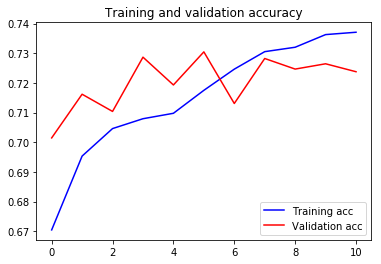

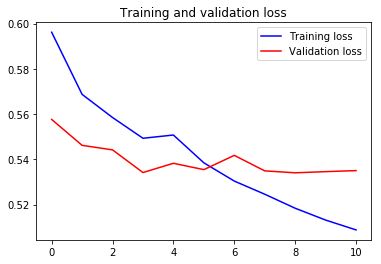

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [48]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.5 else POSITIVE

In [49]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [50]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9497664570808411,
 'elapsed_time': 0.04703187942504883}

In [51]:
predict("oh shit")

{'label': 'NEGATIVE',
 'score': 0.20520807802677155,
 'elapsed_time': 0.041028499603271484}

In [55]:
mytweet = 'finalized_model.sav'
pickle.dump(model, open(mytweet, 'wb'))